In [1]:
from dvc.repo import Repo as DVCRepo
import pathlib
r = DVCRepo(r"D:\ig_pipeline")

In [2]:
# Boolean flag determining whether or not stages will be checked for status
CHECK_PROCESSED = True

In [3]:
stages = r.stages

In [4]:
dir(next(s for s in stages if s.is_data_source))
print(pathlib.Path(next(s for s in stages if s.is_data_source).outs[0].fs_path).name)

processed.max


In [5]:
s_to_deps = {s: [d.fs_path for d in s.deps] for s in stages}
out_to_s = {o.fs_path: s for s in stages for o in s.outs}

In [6]:
import collections
out_to_s_dup = collections.defaultdict(list)
for s in stages:
    for o in s.outs:
        out_to_s_dup[o.fs_path].append(s)

In [7]:
[x for x, v in out_to_s_dup.items() if len(v) > 1]

[]

In [8]:
import networkx as nx

In [9]:
G = nx.DiGraph()

In [10]:
def canonicalize(s):
    if s.is_data_source:
        return pathlib.Path(s.outs[0].fs_path).name
        
    return s.name.split("@")[0] if not s.is_data_source else "data_source"

In [11]:
if CHECK_PROCESSED:
    r.lock.lock()

# Process nodes
for s in s_to_deps.keys():
    this_node = canonicalize(s)
    if this_node not in G.nodes:
        G.add_node(this_node, total=0, changed=0)
        
    if CHECK_PROCESSED:
        G.nodes[this_node]["total"] += 1
        if s.changed():
            G.nodes[this_node]["changed"] += 1
    
# Add dependencies
for s in s_to_deps.keys():
    this_node = canonicalize(s)
    for dep in s_to_deps[s]:
        if dep in out_to_s:
            from_node = canonicalize(out_to_s[dep])
            G.add_edge(from_node, this_node)
            
if CHECK_PROCESSED:
    r.lock.unlock()

In [12]:
for x in nx.topological_sort(G):
    print(x)

processed.max
raw.max
textures
bathroom.max
living.max
proxy
object_list
room_object_list
sanitycheck
export_meshes
object_inventory
object_list_success
combined_room_object_list
sanitycheck_success
export_meshes_success
export_objs
export_objs_success
aggregate_objs
export_scene
aggregate_scenes
aggregate_metadata
pack_dataset


In [13]:
# In mermaid format for pasting into README
for f, t in G.edges:
    print(f"    {f} --> {t}")

    aggregate_metadata --> pack_dataset
    aggregate_objs --> aggregate_metadata
    aggregate_objs --> export_scene
    aggregate_objs --> pack_dataset
    aggregate_scenes --> aggregate_metadata
    aggregate_scenes --> pack_dataset
    export_meshes --> export_meshes_success
    export_meshes --> export_objs
    export_meshes --> export_scene
    export_meshes_success --> export_objs
    export_meshes_success --> export_scene
    export_objs --> aggregate_objs
    export_objs --> export_objs_success
    export_objs_success --> aggregate_objs
    export_scene --> aggregate_scenes
    object_inventory --> aggregate_objs
    object_list --> export_meshes
    object_list --> export_objs
    object_list --> object_inventory
    object_list --> object_list_success
    object_list_success --> export_objs
    room_object_list --> combined_room_object_list
    sanitycheck --> sanitycheck_success
    processed.max --> export_meshes
    processed.max --> object_list
    processed.max --> room

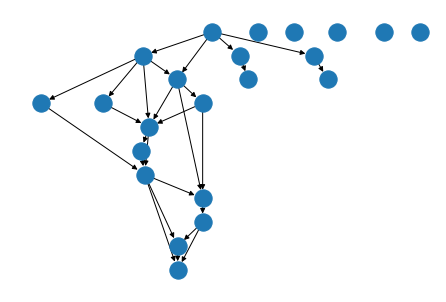

In [14]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos)
plt.show()

In [15]:
if CHECK_PROCESSED:
    print("Completion ratios:")
    for x in nx.topological_sort(G):
        completion_ratio = 1 - (G.nodes[x]["changed"] / G.nodes[x]["total"])
        completion_percentage = int(completion_ratio * 100)
        print(f"{x}: {completion_percentage}%")

Completion ratios:
processed.max: 100%
raw.max: 100%
textures: 100%
bathroom.max: 100%
living.max: 100%
proxy: 100%
object_list: 82%
room_object_list: 100%
sanitycheck: 69%
export_meshes: 100%
object_inventory: 100%
object_list_success: 100%
combined_room_object_list: 0%
sanitycheck_success: 61%
export_meshes_success: 100%
export_objs: 100%
export_objs_success: 100%
aggregate_objs: 100%
export_scene: 87%
aggregate_scenes: 0%
aggregate_metadata: 0%
pack_dataset: 0%
